# Seal Detection Pipeline
---

This jupyter notebook will go through assembling the main components of a complete pipeline for counting seals in high-resolution satellite imagery (figure 1, steps 3 and 4) and show some experimental results with different pipeline designs. The ultimate goal of this pipeline is to perform a pan-Antarctic pack-ice seal census. ** Running this code will require input satellite imagery and at least one GPU with >8GB of memory **

<br>

<img src="jupyter_notebook_images/Base Pipeline.png">

<br>







## Table of contents
---
* [Getting started](#intro)
    * [Setup](#setup)
    * [Visualize training set](#vis_imgs)
* [Pipeline 1 - Seal haulout detector](#1)
    * [Training](#1T)
    * [Validation](#1V)
* [Pipeline 1.1 - Seal haulout detector + count](#1.1)
    * [Training](#1.1T)
    * [Validation](#1.1V)
    * [Testing](#1.1T)
* [Pipeline 1.2 - Seal haulout detector + single seal detector](#1.2)
    * [Training](#1.2T)
    * [Validation](#1.2V)
    * [Testing](#1.2T)

## Getting started<a name="intro"></a>
---

If you followed the *training_set_generation* jupyter notebook (also present in this repo), you should have training sets generated and hyperparameter sets to try out, and be ready to search for a best performing seal detection pipeline.  Output files in this repository are organized as follows: *'./saved_models/{pipeline}/{model_settings}/{model_settings}_{file}'*

### Setup environment<a name="setup"></a>

Before training and validating model/hyperparameter combinations inside the pipelines, we need to load the required python modules and a few global variables. Running this script will also display a list of training classes.

In [2]:
# import required packages
import os
import rasterio
import pandas as pd
import numpy as np
from PIL import Image 
import matplotlib.pyplot as plt
import matplotlib as mpl
from functools import reduce
from utils.model_library import * 

%matplotlib inline
mpl.rcParams['figure.dpi']= 400

# display class names
class_names = sorted([subdir for subdir in os.listdir('./training_sets/training_set_vanilla/training')])
print(class_names)

['crabeater', 'crack', 'emperor', 'glacier', 'ice-sheet', 'marching-emperor', 'open-water', 'other', 'pack-ice', 'rock', 'weddell']


### Visualizing training images (Optional)<a name="vis_imgs"></a>

To get a better sense for what the training set is like, the next cell will display a few random images from the training classes. Displayed images are extracted from a pool of ~70000 training images. 

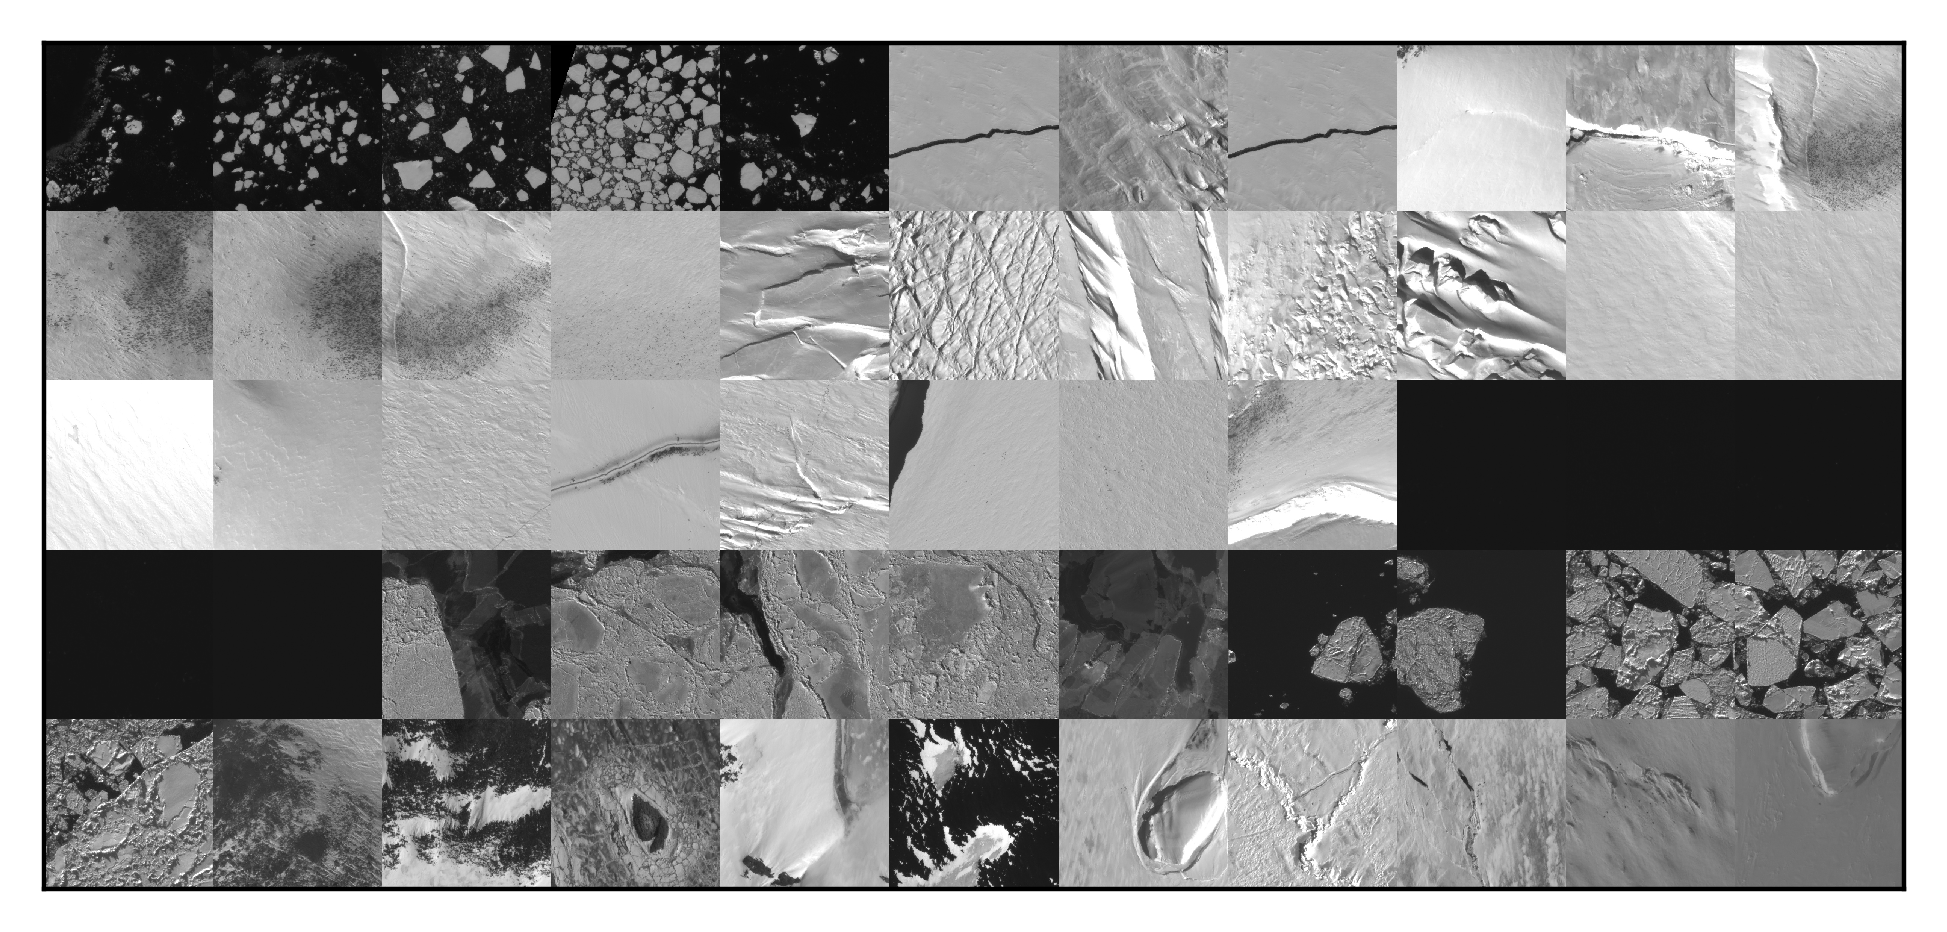

In [2]:
# store images
images = []

# loop over labels
for label in class_names:
    for path, _, files in os.walk('./training_sets/training_set_vanilla/training/{}'.format(label)):
        files = np.random.choice(files, 5)
        for filename in files:
            images.append(np.asarray(Image.open(os.path.join(path, filename))))

images = np.array(images)

# display images 
ncols=len(class_names)
nindex, height, width, intensity = images.shape
nrows = nindex//ncols
assert nindex == nrows*ncols
result = (images.reshape(nrows, ncols, height, width, intensity)
          .swapaxes(1,2)
          .reshape(height*nrows, width*ncols, intensity))

plt.imshow(result)
cur_axes = plt.gca()
cur_axes.axes.get_xaxis().set_visible(False)
cur_axes.axes.get_yaxis().set_visible(False)
plt.show()
    


## Pipeline 1 - haulout detector<a name="1"></a>
---

The simplest pipeline we can use is one that just uses an object classification step to find seal haulouts or penguins colonies. The obvious downside for this approach is that we often have more than one seal in a haulout, which is hardly usefull if we are looking for a count. However, we will use this as a 'pre-preocessing' step, where we narrow down the totality of patches to the subset where the haulout detection CNN flagged groups of seals. To validate the usefulness of this preprocessing step we can compare results obtained with the full pipeline (i.e. haul out detector + count) to one that simply tries to count on all tiles. 

### Training<a name="1T"></a>

The first step to find a best performing model is to train different model setups using our training set. To keep track of which combinations we have tried, how well they performed and the specifics of each model setup, we will store results in folders (under './saved_models') named after each specific model combination.

In [3]:
# generate model combinations
combinations_1 = {'model_architecture': ['Resnet18'] * 4 + ['NasnetA'] * 4,
                  'training_dir': ['training_set_vanilla', 'training_set_multiscale_A'] * 4,
                  'hyperparameter_set': ['A'] * 4 + ['B'] * 4,
                  'cv_weights': ['NO', 'NO', 'WCV', 'WCV'] * 2}

# read as a DataFrame
combinations_1 = pd.DataFrame(combinations_1)
                    
# create folders for resulting files
for row in combinations_1.iterrows():
    mdl = '{}_{}_{}'.format(row[1]['model_architecture'], row[1]['training_dir'],\
                            row[1]['cv_weights'])                     
    if not os.path.exists("./saved_models/Pipeline1/{}".format(mdl)):
        os.makedirs("./saved_models/Pipeline1/{}".format(mdl)) 


We can then provide model combinations created above as arguments to the training script, *train_sealnet.py*. A list of required arguments can be displayed by running the cell below.

In [ ]:
%run train_sealnet.py -h

In [4]:
# iterate over combinations
pipeline = 'Pipeline1'
for row in combinations_1.iterrows():
    
    # read hyperparameters
    t_dir, arch, hyp_st, cv_wgt = row[1]['training_dir'], row[1]['model_architecture'], \
                                  row[1]['hyperparameter_set'], row[1]['cv_weights']
    out = '{}_{}_{}'.format(arch, t_dir, cv_wgt)
    
    # check if model is already trained
    if "{}.tar".format(out) in os.listdir('./saved_models/{}/{}/'.format(pipeline, out)): 
        print('{} was already trained'.format(out))
        continue
    
    print()
    !echo training $out
    print()
    
    # run training
    !python train_sealnet.py --training_dir=$t_dir --model_architecture=$arch \
                             --hyperparameter_set=$hyp_st --cv_weights=$cv_wgt \
                             --output_name=$out --pipeline=$pipeline
      

Resnet18_training_set_vanilla_NO was already trained
Resnet18_training_set_multiscale_A_NO was already trained
Resnet18_training_set_vanilla_WCV was already trained
Resnet18_training_set_multiscale_A_WCV was already trained
NasnetA_training_set_vanilla_NO was already trained
NasnetA_training_set_multiscale_A_NO was already trained
NasnetA_training_set_vanilla_WCV was already trained

training NasnetA_training_set_multiscale_A_WCV

Epoch 1/5
----------
training Loss: 0.1635 training Acc: 0.5979
validation Loss: 1.9550 validation Acc: 0.7784
training time: 2.0h 32m 31s

Epoch 2/5
----------
training Loss: 0.0888 training Acc: 0.7963
validation Loss: 1.6798 validation Acc: 0.8125
training time: 5.0h 4m 50s

Epoch 3/5
----------
training Loss: 0.0617 training Acc: 0.8584
validation Loss: 1.5151 validation Acc: 0.8483
training time: 7.0h 37m 1s

Epoch 4/5
----------
training Loss: 0.0468 training Acc: 0.8911
validation Loss: 0.9815 validation Acc: 0.9002
training time: 10.0h 9m 8s

Epoch 5/

### Validation<a name="1V"></a> 

We can now load the models we just trained to get measurements of precision and recall for all positive classes. For every model combination we trained, *validate_sealnet.py* will run a full validation round and write given label/correct label pairs to a .csv file. The resulting .csv file is then imported by an R script, *plot_confusion_matrix.R*, which saves a confusion matrix figure and a .csv spreadsheet with precision and recall for all classes of interest. 

In [5]:
# DataFrame to combine all metrics 
comb_prec_recall = pd.DataFrame()
pipeline = 'Pipeline1'

# iterate over trained models
for row in combinations_1.iterrows():
    
    # read hyperparameters
    t_dir, arch, hyp_st, cv_wgt = row[1]['training_dir'], row[1]['model_architecture'],\
                                  row[1]['hyperparameter_set'], row[1]['cv_weights']
    out = '{}_{}_{}'.format(arch, t_dir, cv_wgt)
    
    # check if model file is available
    if "{}.tar".format(out) not in os.listdir('./saved_models/{}/{}/'.format(pipeline, out)): 
        print('{} has not been trained yet'.format(out))
        continue
        
    else:
        print()
        !echo validating $out
        print()
        
        #run validation
        !python validate_sealnet.py --training_dir=$t_dir --model_architecture=$arch \
                                    --hyperparameter_set=$hyp_st --model_name=$out \
                                    --pipeline=$pipeline
        
        # extract performance metrics and plot confusion matrix
        !Rscript plot_confusion_matrix.R --input_file=$out --pipeline=$pipeline
        
        # accumulate performance scores
        comb_prec_recall = comb_prec_recall.append(pd.read_csv('./saved_models/{}/{}/{}_prec_recall.csv'.format(pipeline, out, out)))
    
    
# Write combined metrics to csv and plot combined metrics
pooled_data_path = './saved_models/{}/pooled_prec_recall.csv'.format(pipeline)
comb_prec_recall.to_csv(pooled_data_path)
!Rscript plot_comparison.R --input_file=$pooled_data_path \
                           --output_file='./saved_models/Pipeline1/comparison_plot.png' \
                           --x='recall' --y='precision' --facet='label'
    


validating Resnet18_training_set_vanilla_NO

Validation complete in 0.0h 0m 55s
Validation Acc: 0.822759

validating Resnet18_training_set_multiscale_A_NO

Validation complete in 0.0h 0m 28s
Validation Acc: 0.820447

validating Resnet18_training_set_vanilla_WCV

Validation complete in 0.0h 0m 28s
Validation Acc: 0.837914

validating Resnet18_training_set_multiscale_A_WCV

Validation complete in 0.0h 0m 28s
Validation Acc: 0.845363

validating NasnetA_training_set_vanilla_NO

Validation complete in 0.0h 4m 40s
Validation Acc: 0.911636

validating NasnetA_training_set_multiscale_A_NO

Validation complete in 0.0h 4m 41s
Validation Acc: 0.911508

validating NasnetA_training_set_vanilla_WCV

Validation complete in 0.0h 4m 41s
Validation Acc: 0.926535

validating NasnetA_training_set_multiscale_A_WCV

Validation complete in 0.0h 4m 40s
Validation Acc: 0.857950
null device 
          1 


## Pipeline 1.1 - haulout detector + count<a name="1.1"></a>
---

Here we will generate seal counting CNNs, train them and validate them. Seal counting CNNs will be trained to minimize the mean squared error (MSE) between predicted counts and ground-truth counts. Though they will be trained and validated separately from the haul out detector (Pipeline 1), these approaches will be tested on top of the haul out detector and as standalones.

### Training<a name="1.1T"></a>

Similar to the previous pipeline, we will store results in folders (under './saved_models') named after each specific model combination for bookkeeping.

In [3]:
# generate model combinations
combinations_11 = {'model_architecture': ['WideResnetCount'] * 2 + ['Resnet34count'] * 2 \
                                         + ['Resnet18count'] * 2 + ['Resnet50count'] * 2 \
                                         + ['NasnetAcount'] * 2,
                   'training_dir': ['training_set_vanilla','training_set_multiscale_A'] * 5,
                   'hyperparameter_set': ['D'] * 2 + ['A'] * 6 + ['B'] * 2}
        

# read as a DataFrame
combinations_11 = pd.DataFrame(combinations_11)
                    

# create folders for resulting files
for row in combinations_11.iterrows():
    mdl = '{}_{}'.format(row[1]['model_architecture'], row[1]['training_dir'])                     
    if not os.path.exists("./saved_models/Pipeline1.1/{}".format(mdl)):
        os.makedirs("./saved_models/Pipeline1.1/{}".format(mdl)) 

To train a counting model, model combinations created above are used as argument to to a new training script, *train_sealnet_count.py*, which uses MSE loss. It accepts the same arguments as the previous.

In [3]:
# iterate over combinations
pipeline = 'Pipeline1.1'
for row in combinations_11.iterrows():
    
    # read hyperparameters
    t_dir, arch, hyp_st = row[1]['training_dir'], row[1]['model_architecture'], \
                          row[1]['hyperparameter_set']
    out = '{}_{}'.format(arch, t_dir)
    
    # check if model is already trained
    if "{}.tar".format(out) in os.listdir('./saved_models/{}/{}/'.format(pipeline, out)): 
        print('{} was already trained'.format(out))
        continue
    
    print()
    !echo training $out
    print()
    
    # run training
    !python train_sealnet_count.py --training_dir=$t_dir --model_architecture=$arch \
                                   --hyperparameter_set=$hyp_st --output_name=$out  \
                                   --pipeline=$pipeline
    

WideResnetCount_training_set_vanilla was already trained
WideResnetCount_training_set_multiscale_A was already trained
Resnet34count_training_set_vanilla was already trained

training Resnet34count_training_set_multiscale_A

Epoch 1/5
----------
training Loss: 0.1149
validation Loss: 0.5833
training time: 0.0h 21m 24s

Epoch 2/5
----------
training Loss: 0.0996
validation Loss: 0.5940
training time: 0.0h 42m 4s

Epoch 3/5
----------
training Loss: 0.0975
validation Loss: 0.8675
training time: 1.0h 2m 32s

Epoch 4/5
----------
training Loss: 0.0950
validation Loss: 0.6331
training time: 1.0h 22m 16s

Epoch 5/5
----------
training Loss: 0.0934
validation Loss: 0.2910
training time: 1.0h 41m 58s

Training complete in 1.0h 41m 58s

training Resnet18count_training_set_vanilla

Epoch 1/5
----------
training Loss: 0.1102
validation Loss: 0.3349
training time: 0.0h 16m 53s

Epoch 2/5
----------
training Loss: 0.1021
validation Loss: 0.3720
training time: 0.0h 33m 15s

Epoch 3/5
----------
trai

### Validation<a name="1.1V"></a>

Validating counting models is a little bit simpler then with seal haul out models: for each model we just extract the mean squared error, running time at inference and number of model parameters. To test if classifying images before counting is helpful, performance stats during counting validation will be later compared to those where images where classified prior to counting.


In [8]:
# DataFrame to combine all metrics 
comb_mse = pd.DataFrame()
pipeline = 'Pipeline1.1'

# iterate over trained models
for row in combinations_11.iterrows():
    
    # read hyperparameters
    t_dir, arch, hyp_st = row[1]['training_dir'], row[1]['model_architecture'],\
                          row[1]['hyperparameter_set']
    out = '{}_{}'.format(arch, t_dir)
    
    # check if model file is available
    if "{}.tar".format(out) not in os.listdir('./saved_models/{}/{}/'.format(pipeline, out)): 
        print('{} has not been trained yet'.format(out))
        continue
    
    else:
        print()
        !echo validating $out
        print()
        
        #run validation
        !python validate_sealnet.py --training_dir=$t_dir --model_architecture=$arch \
                                    --hyperparameter_set=$hyp_st --model_name=$out \
                                    --pipeline=$pipeline
        
        # extract performance metrics and plot confusion matrix
        !Rscript get_mse.R --input_file=$out --pipeline=$pipeline
        
        # accumulate performance scores
        comb_mse = comb_mse.append(pd.read_csv('./saved_models/{}/{}/{}_mse.csv'.format(pipeline, out, out)))
    
# generate counting benchmarks and add them to the combined metrics DataFrame
!Rscript generate_benchmarks.R --input_file='Resnet18count_training_set_vanilla' --pipeline=$pipeline
comb_mse = comb_mse.append(pd.read_csv('./saved_models/{}/benchmarks.csv'.format(pipeline)))

# write combined metrics to csv and plot combined metrics
pooled_data_path = './saved_models/{}/pooled_mse.csv'.format(pipeline)
comb_mse.to_csv(pooled_data_path)

# total predicted vs ground-truth plot
!Rscript plot_comparison.R --input_file=$pooled_data_path \
                           --output_file='./saved_models/Pipeline1.1/comparison_final_count.png' \
                           --x='total_predicted' --y='total_ground_truth'
        
# inference time vs. MSE plot
!Rscript plot_comparison.R --input_file=$pooled_data_path \
                           --output_file='./saved_models/Pipeline1.1/comparison_mse.png' \
                           --x='running_time' --y='MSE'

# precision vs. recall plot
!Rscript plot_comparison.R --input_file=$pooled_data_path \
                           --output_file='./saved_models/Pipeline1.1/comparison_prec_recall.png' \
                           --x='recall' --y='precision'


validating WideResnetCount_training_set_vanilla

Validation complete in 0.0h 0m 6s

validating WideResnetCount_training_set_multiscale_A

Validation complete in 0.0h 0m 7s

validating Resnet34count_training_set_vanilla

Validation complete in 0.0h 0m 47s

validating Resnet34count_training_set_multiscale_A

Validation complete in 0.0h 0m 45s

validating Resnet18count_training_set_vanilla

Validation complete in 0.0h 0m 36s
Resnet18count_training_set_multiscale_A has not been trained yet
Resnet50count_training_set_vanilla has not been trained yet
Resnet50count_training_set_multiscale_A has not been trained yet
NasnetAcount_training_set_vanilla has not been trained yet
NasnetAcount_training_set_multiscale_A has not been trained yet
Warning message:
Removed 1 rows containing missing values (geom_point). 
null device 
          1 
null device 
          1 
Warning message:
Removed 2 rows containing missing values (geom_point). 
null device 
          1 


### Testing -- ablation study<a name="1.1T"></a>

The idea of this step is to test the validity of the full pipeline (classify + count) against one that will simply count in every patch. To do that we will run *predict_sealnet.py* on our validation images with the best classification model from pipeline 1, keep the names of those that have any seals in it and get the MSE of counting models on that subset. We will then copy positive images to ablation sets. 

In [5]:
# check whether images were already classified
if 'classified_patches.csv' not in os.listdir('./saved_models/Pipeline1/'):

    # classify validation images with a model from Pipeline 1
    !python predict_sealnet_ablation.py --pipeline='Pipeline1' \
                                        --model_architecture='NasnetA' \
                                        --training_dir='training_set_vanilla' \
                                        --hyperparameter_set='B' \
                                        --model_name='NasnetA_training_set_vanilla_NO' \
                                        --positive_classes='crabeater_weddell'

# load csv with list of classified images
to_count = pd.read_csv('./saved_models/Pipeline1/classified_patches.csv')['file'].values

# create ablation experiment folder inside training_sets
for ts in ['training_set_vanilla', 'training_set_multiscale_A']:
    if not os.path.exists("./training_sets/{}_ablation/validation/pos_patches".format(ts)):
        os.makedirs("./training_sets/{}_ablation/validation/pos_patches".format(ts)) 
    # copy images flagged as positive to ablation experiment set folders
    for path, _, files in os.walk('./training_sets/{}'.format(ts)):
        for filename in files:
            if filename in to_count:
                file_path = os.path.join(path, filename)
                img = Image.open(file_path)
                img.save('./training_sets/{}_ablation/validation/pos_patches/{}'.format(ts, filename))
        

We can now loop through positive patches with counting CNNs, get MSE and total count for positive images and compare results with those of Pipeline1.1 validation (pura counting pipeline). 

In [9]:
# Create DataFrame to combine metrics
comb_mse = pd.DataFrame()
pipeline = 'Pipeline1.1'

# iterate over trained models
for row in combinations_11.iterrows():
    
    # read hyperparameters
    t_dir, arch, hyp_st = row[1]['training_dir'], row[1]['model_architecture'],\
                          row[1]['hyperparameter_set']
    out = '{}_{}'.format(arch, t_dir)
    
    # check if model file is available
    if "{}.tar".format(out) not in os.listdir('./saved_models/{}/{}/'.format(pipeline, out)): 
        print('{} has not been trained yet'.format(out))
        continue
        
    else:
        print()
        !echo validating $out
        print()
        
        #run validation
        !python validate_sealnet.py --training_dir=$t_dir --model_architecture=$arch \
                                    --hyperparameter_set=$hyp_st --model_name=$out \
                                    --pipeline=$pipeline --ablation=1
        
        # extract performance metrics and plot confusion matrix
        !Rscript get_mse.R --input_file=$out --pipeline=$pipeline
        
        # accumulate performance scores
        comb_mse = comb_mse.append(pd.read_csv('./saved_models/{}/{}/{}_mse.csv'.format(pipeline, out, out)))
    
    
# generate counting benchmarks and add them to the combined metrics DataFrame
!Rscript generate_benchmarks.R --input_file='Resnet18count_training_set_vanilla' --pipeline=$pipeline
comb_mse = comb_mse.append(pd.read_csv('./saved_models/{}/benchmarks.csv'.format(pipeline)))

# write combined metrics to csv and plot combined metrics
pooled_data_path = './saved_models/{}/pooled_mse.csv'.format(pipeline)
comb_mse.to_csv(pooled_data_path)

# total predicted vs ground-truth plot
!Rscript plot_comparison.R --input_file=$pooled_data_path \
                           --output_file='./saved_models/Pipeline1.1/comparison_final_count_ablation.png' \
                           --x='total_predicted' --y='total_ground_truth'
        
# inference time vs. MSE plot
!Rscript plot_comparison.R --input_file=$pooled_data_path \
                           --output_file='./saved_models/Pipeline1.1/comparison_mse_ablation.png' \
                           --x='running_time' --y='MSE'

# precision vs. recall plot
!Rscript plot_comparison.R --input_file=$pooled_data_path \
                           --output_file='./saved_models/Pipeline1.1/comparison_prec_recall_ablation.png' \
                           --x='recall' --y='precision'


validating WideResnetCount_training_set_vanilla

Validation complete in 0.0h 0m 1s

validating WideResnetCount_training_set_multiscale_A

Validation complete in 0.0h 0m 1s

validating Resnet34count_training_set_vanilla

Validation complete in 0.0h 0m 4s

validating Resnet34count_training_set_multiscale_A

Validation complete in 0.0h 0m 4s

validating Resnet18count_training_set_vanilla

Validation complete in 0.0h 0m 4s
Resnet18count_training_set_multiscale_A has not been trained yet
Resnet50count_training_set_vanilla has not been trained yet
Resnet50count_training_set_multiscale_A has not been trained yet
NasnetAcount_training_set_vanilla has not been trained yet
NasnetAcount_training_set_multiscale_A has not been trained yet
null device 
          1 
null device 
          1 
null device 
          1 


## Pipeline 1.2 - haulout detector + single seal detector<a name="1.2"></a>
---

Pipeline 1.2 adds an individual seal detection CNN on top of the seal haul out detector (Pipeline 1. Individual seal detection CNNs will be trained to localize detection points and minimize the MSE between the number of detections and ground-truth count. In this approach, counts will be obtained by adding up the number of detections. Though they will be trained and validated separately from the haul out detector (Pipeline 1), these approaches will be tested on top of the haul out detector and as standalones.

### Training<a name="1.2T"></a>

### Validation<a name="1.2V"></a>

### Testing -- ablation study<a name="1.2T"></a>

## Validation - scene level

The first step to validate models at the scene level is to tile out rasters to model input sizes. The following cell will search for all rasters in a dir, check if they are present in the scene_bank (see  *training_set_generation.ipynb*), store an affine matrix for that scene to go from the tile's index in the scene to projected coordinates and create tiles with the correct dimensions(including multi-scale models) for all model architectures in the 'combinations' DataFrame. 

In [ ]:
# load scene bank
scene_bank = pd.read_csv('./training_sets/seals_scene_bank.csv')

# point to raster dir
raster_dir = '/home/bento/imagery'

# create output folder
%mkdir './tiled_images'

# store data transforms
affine_transforms = {}

# loop through rasters creating tiled versions
print('\nTiling rasters:\n')
for path, _, files in os.walk(raster_dir):
    # filter rasters to include only ones present in the scene bank
    files = [file for file in files if file in pd.unique(scene_bank['scene'])]
    for count, filename in enumerate(files):
        filename_lower = filename.lower()
        input_path = (os.path.join(path, filename))
        # extract data transform to go from raster index to ESPG3031 coordinates
        with rasterio.open(input_path) as src:
            affine_transforms[filename] = [src.transform[1], src.transform[2], src.transform[0], src.transform[4], src.transform[5], src.transform[3]]
        # loop over models
        for row in combinations_haul.iterrows():
            # get model input size
            input_size = model_archs[row[1]['model_architecture']]
            ts_scales = training_sets[row[1]['training_dir']]['scale_bands']
            scales = [str(int(input_size * scale / ts_scales[0])) for scale in ts_scales]
            scale_bands = reduce(lambda x,y: x + '_' + y, scales)
            output_folder = './tiled_images/{}/{}'.format(input_path, scale_bands)
            # create a tiled out image for that model if it doesn't exist
            if os.path.exists(output_folder):
                print('  {} was already split into tiles'.format(filename))
                continue
            !python tile_raster.py --scale_bands=$scale_bands  --input_image=$input_path --output_folder='./tiled_images'
        print('\nProcessed {} out of {} rasters'.format(count + 1, len(files)))

# write data transforms to csv
affine_transforms = pd.DataFrame(affine_transforms)
affine_transforms.to_csv('affine_transforms.csv')

With rasters tiled to the correct dimensions we can now run validation at the scene level. This procedure will work as follows: for each model, classify all images tiled in the previous step and save classification results to a pandas DataFrame. Results will be compared with the scene_bank to measure precision and recall at detecting which scenes contain positive entries (i.e. seals, penguins or even both, depending on the scene_bank being used). Locations marked as having seal haulouts will be used to detect individual seals and validate models at the seal level. To get validation results, run the following cell: 

In [20]:
# loop through models classifying tiles
print('\nClassifying tiles:\n')
for row in combinations_haul.iterrows():
    # store model classifications to get seal locations for seal level validation
    val_scene_model = pd.DataFrame()
    
    # get model settings
    arch = row[1]['model_architecture']
    model_name = row[1]['output_name']
    t_dir = row[1]['training_dir']
    hyp_st = row[1]['hyperparameter_set']
    
    # check if model was already processed
    if "{}_scene_val.csv".format(model_name) in os.listdir('./saved_models/haulout/{}/'.format(model_name)): 
        print('  Tiles were already processed with {}'.format(model_name))
        continue
    
    # get scale bands
    input_size = model_archs[arch]['input_size']
    ts_scales = training_sets[t_dir]['scale_bands']
    scales = [str(int(input_size * scale / ts_scales[0])) for scale in ts_scales]
    scale_bands = reduce(lambda x,y: x + '_' + y, scales)
    
    # loop through tiled rasters
    scenes = os.listdir('./tiled_images')
    print('\nClassifying tiled scenes with {}:'.format(model_name))
    for count, scene in enumerate(scenes):
        input_folder = './tiled_images/{}/{}'.format(scene, scale_bands)
        %run predict_sealnet.py --training_dir=$t_dir --model_architecture=$arch --hyperparameter_set=$hyp_st --model_name=$model_name --data_dir=$input_folder --affine_transforms='affine_transforms.csv' --scene=$scene        
        val_scene_model = val_scene_model.append(pd.read_csv('./saved_models/haulout/{}/{}_scene_val_tmp.csv'.format(model_name, model_name)), ignore_index=True)
        print('\n  Classified {} out of {} tiled scenes'.format(count + 1, len(scenes)))
    
    # save final classifications to csv and cleanup temporary stats
    val_scene_model.to_csv('./saved_models/haulout/{}/{}_scene_val.csv'.format(model_name, model_name))
    to_rm = './saved_models/haulout/{}/{}_scene_val_tmp.csv'.format(model_name, model_name)
    !rm $to_rm

# get precision and recall for classification at all scene banks
comb_prec_rec = pd.DataFrame()

print('\nValidating models:\n')
# loop thorugh models again to get precision and recall
for count, row in enumerate(combinations_haul.iterrows()):
    # get model name
    model_name = row[1]['output_name']
    # get validation stats
    %run validate_sealnet_scene.py --model_name=$model_name
    comb_prec_rec = comb_prec_rec.append(pd.read_csv('./saved_models/haulout/{}/{}_scene_prec_recall.csv'.format(model_name, model_name)), ignore_index=True)
    print('  Validated {} out of {} models'.format(count + 1, len(combinations_haul)))
    
# save combined precision recall to csv and plot it
comb_prec_rec.to_csv('./saved_models/haulout/pooled_scene_prec_recall.csv', index=False)
!Rscript plot_comparison.R './saved_models/haulout/pooled_scene_prec_recall.csv' './saved_models/haulout/scene_comparison_plot.png'




Classifying tiles:

  Tiles were already processed with model1
  Tiles were already processed with model2
  Tiles were already processed with model3
  Tiles were already processed with model4
  Tiles were already processed with model5
  Tiles were already processed with model6
  Tiles were already processed with model7
  Tiles were already processed with model8

Validating models:

  Validated 1 out of 8 models
  Validated 2 out of 8 models
  Validated 3 out of 8 models
  Validated 4 out of 8 models
  Validated 5 out of 8 models
  Validated 6 out of 8 models
  Validated 7 out of 8 models
  Validated 8 out of 8 models
Loading required package: methods
null device 
          1 


## Validation -- single seal level

With seal haulout locations determined, we can go ahead and try to count seals inside flagged seal haul out. 

In [1]:
%run train_sealnet_count.py --training_dir="training_set_vanilla_count" --model_architecture='NasnetACount' --hyperparameter_set='B' --cv_weights='NO' --output_name='count-ception'


Epoch 1/5
----------
training Loss: 2.1029
validation Loss: 9.4041
training time: 0.0h 37m 56s

Epoch 2/5
----------
training Loss: 2.1184
validation Loss: 9.4700
training time: 1.0h 15m 25s

Epoch 3/5
----------
training Loss: 2.0883
validation Loss: 9.3499
training time: 1.0h 53m 40s

Epoch 4/5
----------
training Loss: 2.0652
validation Loss: 9.5114
training time: 2.0h 33m 18s

Epoch 5/5
----------


Process Process-21:
Process Process-23:
Process Process-24:
Process Process-22:


KeyboardInterrupt: 

Traceback (most recent call last):
  File "/home/bento/anaconda3/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/bento/anaconda3/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/bento/anaconda3/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 57, in _worker_loop
    samples = collate_fn([dataset[i] for i in batch_indices])
  File "/home/bento/anaconda3/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 57, in <listcomp>
    samples = collate_fn([dataset[i] for i in batch_indices])
  File "/home/bento/PycharmProjects/Seals_branches/Master/Seals/utils/data_loader_train_det.py", line 110, in __getitem__
    sample = self.loader(path)
  File "/home/bento/PycharmProjects/Seals_branches/Master/Seals/utils/data_loader_train_det.py", line 167, in default_loader
    return pil_loader(path)
  File "/home/bento/PycharmProjects/Seals_branches/Master/

In [1]:
%run train_sealnet_count_e2e.py --training_dir="training_set_vanilla_count" --model_architecture='NasnetAe2e' --hyperparameter_set='E' --cv_weights='NO' --output_name='NasnetAe2e_V'
%run train_sealnet_count_e2e.py --training_dir="training_set_multiscale_A_count" --model_architecture='NasnetAe2e' --hyperparameter_set='E' --cv_weights='NO' --output_name='NasnetAe2e_MS'

Epoch 1/10
----------
training Loss: 2.2607 Acc: 0.7001
validation Loss: 14.8348 Acc: 0.6339
training time: 1.0h 54m 43s

Epoch 2/10
----------
training Loss: 2.2659 Acc: 0.8595
validation Loss: 18.3803 Acc: 0.5907
training time: 3.0h 49m 29s

Epoch 3/10
----------
training Loss: 2.1439 Acc: 0.8928
validation Loss: 22.7197 Acc: 0.5870
training time: 5.0h 44m 12s

Epoch 4/10
----------
training Loss: 2.2004 Acc: 0.9147
validation Loss: 22.0916 Acc: 0.5890
training time: 7.0h 38m 49s

Epoch 5/10
----------
training Loss: 2.2068 Acc: 0.9235
validation Loss: 20.3537 Acc: 0.5889
training time: 9.0h 33m 22s

Epoch 6/10
----------
training Loss: 2.1304 Acc: 0.9363
validation Loss: 22.2404 Acc: 0.5895
training time: 11.0h 27m 54s

Epoch 7/10
----------
training Loss: 2.1302 Acc: 0.9412
validation Loss: 21.8812 Acc: 0.5890
training time: 13.0h 22m 26s

Epoch 8/10
----------
training Loss: 2.0879 Acc: 0.9478
validation Loss: 25.9171 Acc: 0.5904
training time: 15.0h 17m 2s

Epoch 9/10
----------


FileNotFoundError: [Errno 2] No such file or directory: 'saved_models/single_seal/NasnetAe2e_V/NasnetAe2e_V.tar'

Epoch 1/10
----------


Process Process-54:
Process Process-51:
Process Process-53:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Process Process-52:
  File "/home/bento/anaconda3/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/bento/anaconda3/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/bento/anaconda3/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/bento/anaconda3/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/bento/anaconda3/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/bento/anaconda3/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 52, in _worker_loop
    r = index_queue.get()
  File "/home/bento/anaconda3/lib/python3.6/multiprocessing/process

KeyboardInterrupt: 

Traceback (most recent call last):
  File "/home/bento/anaconda3/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/bento/anaconda3/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/bento/anaconda3/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 57, in _worker_loop
    samples = collate_fn([dataset[i] for i in batch_indices])
  File "/home/bento/anaconda3/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 57, in <listcomp>
    samples = collate_fn([dataset[i] for i in batch_indices])
  File "/home/bento/PycharmProjects/Seals_branches/Master/Seals/utils/data_loader_train_det.py", line 118, in __getitem__
    sample = self.loader(path)
  File "/home/bento/PycharmProjects/Seals_branches/Master/Seals/utils/data_loader_train_det.py", line 167, in default_loader
    return pil_loader(path)
  File "/home/bento/PycharmProjects/Seals_branches/Master/

In [2]:
%mkdir classified_images
for x in class_names:
    dir = './classified_images/' + x
    %mkdir -v $dir
    
%run predict_sealnet.py "training_set_vanilla" "NasnetA" "model5" "./to_classify"

NameError: name 'class_names' is not defined

In [3]:
path = './saved_models/haulout'
for folder in os.listdir(path):
    folder_path = os.path.join(path, folder)
    %run rename_model.py --folder=$folder_path --target_name=$folder
    

NotADirectoryError: [Errno 20] Not a directory: './saved_models/haulout/pooled_haul_prec_recall.csv'